In [1]:
import os
os.getcwd()
os.chdir("../..")
os.getcwd()

'/Users/mariusmahiout/Documents/repos/ising_core/python/src'

In [4]:
import sys
import os

path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)

import ising
import os
import sys
import time

import preprocessing as pre
import model_eval as eval
import utils as utils
import misc_plotting as misc_plotting
import isingfitter as fitter

os.chdir("../..")
os.getcwd()

import numpy as np
import matplotlib.pyplot as plt
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import pandas as pd
import tqdm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import seaborn as sns
sns.set_theme()
sns.set_style(rc = {'axes.facecolor': '#e5ecf6'})

In [5]:
data_folder = "./data/"
mouse_name = "Angie"

def load_params(num_units: int, data_folder: str, mouse_name: str):
    return np.load(data_folder + "params/" + f'params_{mouse_name}_{num_units}.npy', allow_pickle=True).item()

num_units_range = range(10, 210, 10)

params = dict(
    (num_units, load_params(num_units, data_folder, mouse_name)) for num_units in num_units_range
)

In [6]:
# EQ params
eq_couplings = dict(
    (num_units, params[num_units]["eq_couplings"]) for num_units in num_units_range
)
eq_fields = dict(
    (num_units, params[num_units]["eq_fields"]) for num_units in num_units_range
)

# NEQ params
neq_couplings = dict(
    (num_units, params[num_units]["neq_couplings"]) for num_units in num_units_range
)
neq_fields = dict(
    (num_units, params[num_units]["neq_fields"]) for num_units in num_units_range
)

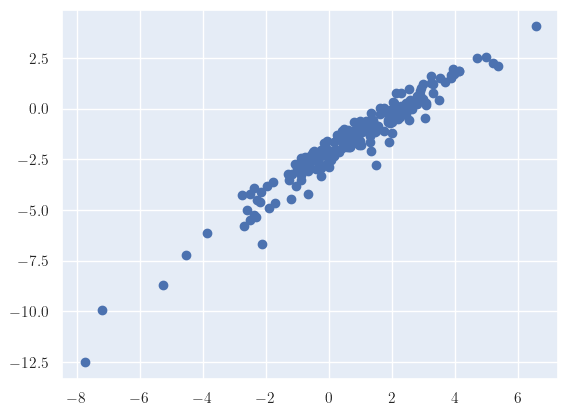

In [7]:
def get_coupling_sums(J):    
    num_units = len(J)
    coupling_sums = [0 for _ in range(num_units)]
    for i in range(num_units):
        for j in [k for k in range(num_units) if k != i]:
            coupling_sums[i] += J[i, j]
    return coupling_sums

num_units = 190
J_sums = get_coupling_sums(neq_couplings[num_units])

plt.scatter(J_sums, neq_fields[num_units])


In [8]:
def get_av_magnetization(states):
    N, num_bins = states.shape
    m_av = np.sum(np.abs(np.sum(states, axis=0)) / N)
    return m_av / num_bins

def get_av_susceptibility(states, T):
    N = states.shape[0]
    M = np.sum(states, axis=0) # array of length num_bins
    M_av = np.mean(M)
    M_sq_av = np.mean(M ** 2)
    return (M_sq_av - M_av ** 2) / (T * N)

In [112]:
num_units = 160

J, h = eq_couplings[num_units], eq_fields[num_units]

num_betas = 500
beta_range = np.linspace(0, 2, num_betas)
av_mag = dict(
    (beta, None) for beta in beta_range
)
av_sus = dict(
    (beta, None) for beta in beta_range
)

for beta in beta_range:
    model = ising.EqModel(J * beta, h * beta)
    sim = model.simulate(15_000, 5_000)

    av_mag[beta] = get_av_magnetization(sim.getStates())
    av_sus[beta] = get_av_susceptibility(sim.getStates(), T=1/beta)



/var/folders/ln/clpmfsfn6vv4rb_n1mbgjk4w0000gn/T/ipykernel_83227/4055049989.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  av_sus[beta] = get_av_susceptibility(sim.getStates(), T=1/beta)


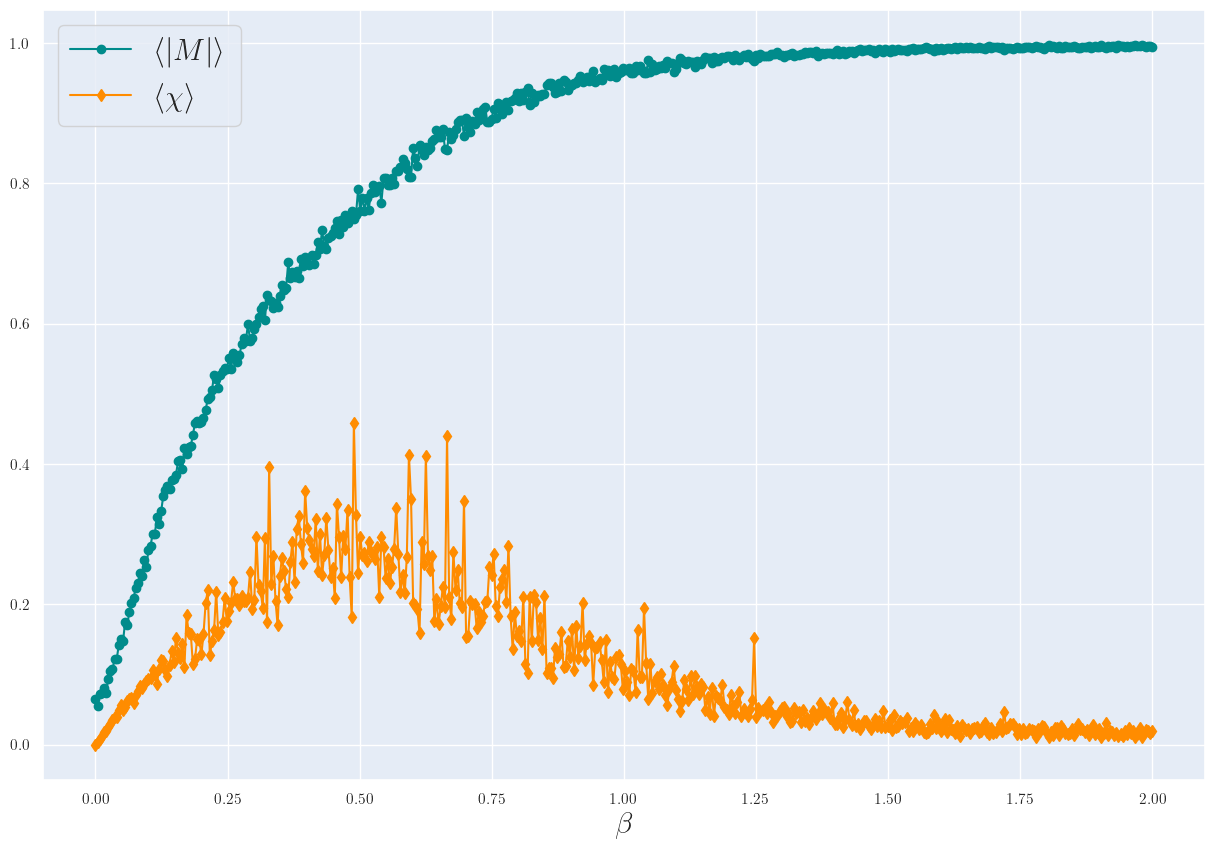

In [113]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(beta_range, list(av_mag.values()), marker='o', color="darkcyan", label=r"$\langle |M| \rangle$")
ax.plot(beta_range, list(av_sus.values()), marker='d', color="darkorange", label=r"$\langle \chi \rangle$")

ax.set_xlabel(r"$\beta$", fontsize=22)
ax.legend(fontsize=22)

plt.savefig("neural_phase_transition.pdf")

plt.show()


# Parameter analysis

Here we're going to do a bit of parameter analysis -- this is the place to build plots such as network graphs, coupling distribution plots etc.

Some ideas:
- Can we say anything about the distribution of couplings? Such as
    - Probability distribution
    - Network structure (e.g., small-world) Note: maybe check what we might expect in M2 and PPC -- would be great to see some characteristic signs of connectivity!

- Are the fields log-normally distributed? I heard somewhere that the mean firing rate should have this distribution, and I guess the fields contribute to this


- I think the Hamiltonian can be computed on the basis of fields, couplings, and a state, so we can track the energy of states during simulation with this!
The energy will basically be a 1-D time series
- In this way, can we obtain a distribution over energies by sampling?